In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import json
import ntpath
import mixamo_helper as mm_helper

## **load mixamo json**

In [2]:
json_object = None
file_name = 'output/mixamo_T_pose.gif.json_mixamo.json' 
with open(file_name) as f:
    json_object = json.load(f)

In [3]:
name_idx_map = mm_helper.get_mixamo_name_idx_map()

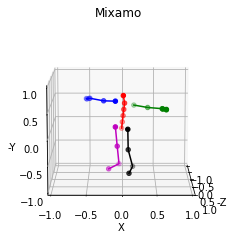

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'score': 0.9990859627723694, 'name': 'Hips', 'parent': -1}
{'x': 0.0918450579047203, 'y': 0.008321262896060944, 'z': -0.06470819562673569, 'score': 0.9990695118904114, 'name': 'LeftLeg', 'parent': 0}
{'x': -0.09308415651321411, 'y': -0.008823947049677372, 'z': 0.0650477483868599, 'score': 0.9991024136543274, 'name': 'RightLeg', 'parent': 0}


In [4]:
current_frame = 55
mm_helper.draw_mixamo(json_object, current_frame, 0)
current_keypoints = json_object["frames"][current_frame]["keypoints3D"]
rightleg_idx = name_idx_map["RightLeg"]
leftleg_idx = name_idx_map["LeftLeg"]
hips_idx = name_idx_map["Hips"]
spine_idx = name_idx_map["Spine"]
print(current_keypoints[hips_idx])
print(current_keypoints[leftleg_idx])
print(current_keypoints[rightleg_idx])

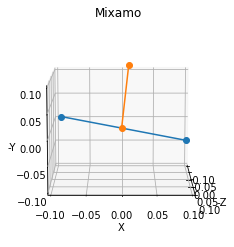

In [5]:
draw_list = [[rightleg_idx,leftleg_idx], [hips_idx, spine_idx]]

mm_helper.draw_list(json_object, current_frame,draw_lists=draw_list, range= 0.1, azim= 0)

## **Math**

In [6]:
import glm
import pyglm_helper as glmh

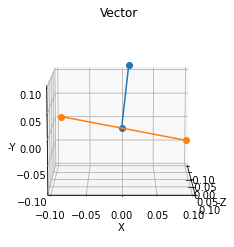

vec3(    0.0918451,   0.00832126,   -0.0647082 )
vec3(   -0.0930842,  -0.00882395,    0.0650477 )


In [7]:
glm_list, visibility_list, parent_list = mm_helper.frame_json_to_glm_vec_list(json_object, current_frame)
hip_v = glm_list[hips_idx]
spine_v = glm_list[spine_idx]
leftleg_v = glm_list[leftleg_idx]
rightleg_v = glm_list[rightleg_idx]

glmh.draw_list([hip_v, spine_v,leftleg_v, rightleg_v], [[0, 1],[2,3]], azim = 0, range = 0.1)
print(leftleg_v)
print(rightleg_v)

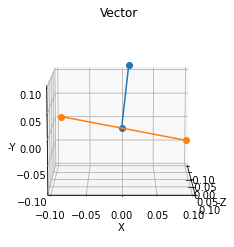

In [15]:
transform = glm.rotate(glm.mat4(1.0), glm.radians(0), glm.vec3(0.0, 0.0, 1.0))
glmh.draw_list([transform*hip_v, transform*spine_v, transform*leftleg_v, transform*rightleg_v], [[0, 1],[2,3]], azim = 0, range = 0.1)


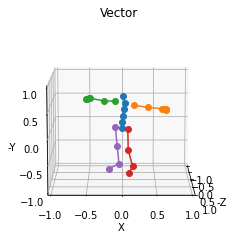

In [17]:
idx_group = mm_helper.get_idx_group()
glmh.draw_list([transform*v for v in glm_list], idx_group, azim=0)